In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os

import datetime
import random
from tqdm import tqdm
from gensim.models import Word2Vec 

from tensorflow import keras 
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from sklearn.manifold import TSNE
import warnings;
warnings.filterwarnings('ignore')

print("Keras version " + keras.__version__)
print("Tensorflow version " + tf.__version__)

Keras version 2.4.0
Tensorflow version 2.4.1


In [2]:
# mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# set base path
base_path = '/content/drive/My Drive/DATA2040_Final_Project_YARD' # group's personal drive path

In [4]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv(base_path + '/data/movies.csv', sep='\t', encoding='latin-1')
df_ratings = pd.read_csv(base_path + '/data/ratings.csv', sep='\t', encoding='latin-1',
                        usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

In [5]:
df = pd.merge(df_movies,df_ratings)

In [6]:
df.head()

,Unnamed: 0,movie_id,title,genres,user_id,rating,timestamp
0,0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,0,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,0,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,0,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,0,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [7]:
df.dropna(inplace=True)

In [8]:
df['movie_id']= df['movie_id'].astype(str)

In [9]:
users = df["user_id"].unique().tolist()

In [10]:
random.shuffle(users)

# extract 90% of user ID's
users_train = [users[i] for i in range(round(0.9*len(users)))]

# split data into train and validation set
train_df = df[df['user_id'].isin(users_train)]
validation_df = df[~df['user_id'].isin(users_train)]

In [11]:
#list to capture watch history of the users
watch_train = []

# populate the list with the movie ID
for i in tqdm(users_train):
    temp = train_df[train_df["user_id"] == i]["movie_id"].tolist()
    watch_train.append(temp)

100%|██████████| 5436/5436 [00:09<00:00, 566.62it/s]


In [12]:
#list to capture watch history of the users
watch_val = []

# populate the list with the movie ID
for i in tqdm(validation_df['user_id'].unique()):
    temp = validation_df[validation_df["user_id"] == i]["movie_id"].tolist()
    watch_val.append(temp)

100%|██████████| 604/604 [00:00<00:00, 1097.91it/s]


In [13]:
# train word2vec model

# window=8 sg=skip-gram hs=negative sampling negative=negative sampling noise=10, 
#alpha=initial learning rate, min_alpha = learning rate will linearly drop to this, seed=34
model = Word2Vec(window = 8, sg = 1, hs = 0,
                 negative = 15, 
                 alpha=0.001, min_alpha=0.0001,
                 seed = 34)

model.save(base_path + '/models/' + 'word2vec_cbf.model')

In [14]:
model = Word2Vec.load(base_path + '/models/' + 'word2vec_cbf.model')

model.build_vocab(watch_train, progress_per=250)

model.train(watch_train, total_examples = model.corpus_count, 
            epochs=20, report_delay=1)

(17962519, 17999140)

In [15]:
print(model)

Word2Vec(vocab=3396, size=100, alpha=0.001)


In [16]:
X = model[model.wv.vocab]
X.shape

(3396, 100)

In [23]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    plt.savefig(base_path + '/figures/plt/' + 'tsne.jpg')

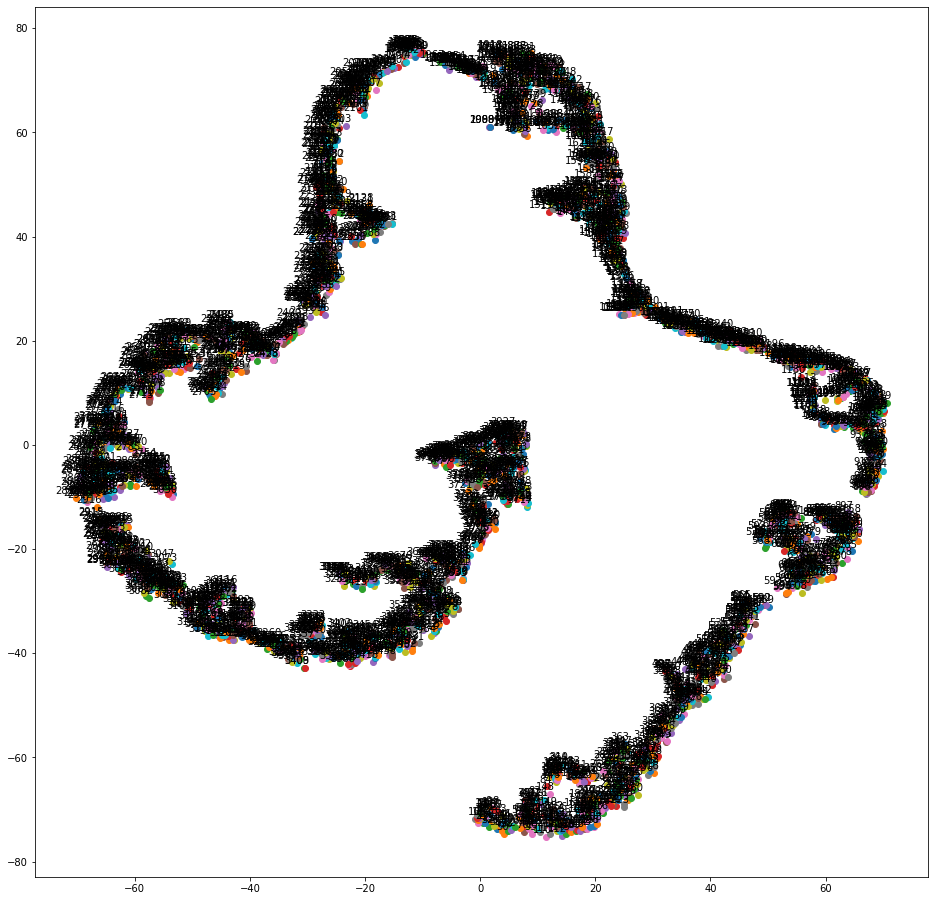

<Figure size 432x288 with 0 Axes>

In [24]:
tsne_plot(model)

In [17]:
watch = train_df[["movie_id", "title"]]

# remove duplicates
watch.drop_duplicates(inplace=True, subset='movie_id', keep="last")

# create movie id and tittle dictionary
watch_dict = watch.groupby('movie_id')['title'].apply(list).to_dict()

In [18]:
def similar_watch(v, n = 6):
    
    # not using most_similar here ()
    # find the top - n most similar words by vector


    # extract most similar movies for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar movies
    new_ms = []
    for j in ms:
        pair = (watch_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

In [19]:
print(watch_dict['200'])
similar_watch(model['200'])

['Tie That Binds, The (1995)']


[('Bushwhacked (1995)', 0.9971842765808105),
 ('Reckless (1995)', 0.9965729713439941),
 ('Total Eclipse (1995)', 0.9961230158805847),
 ('Cure, The (1995)', 0.9952120780944824),
 ('Three Wishes (1995)', 0.9951863884925842),
 ('Wild Bill (1995)', 0.9945678114891052)]

In [20]:
print(watch_dict['1'])
similar_watch(model['1'])

['Toy Story (1995)']


[('Jumanji (1995)', 0.9779865741729736),
 ('Heat (1995)', 0.9763370752334595),
 ('American President, The (1995)', 0.9754705429077148),
 ('Grumpier Old Men (1995)', 0.9728804230690002),
 ('Get Shorty (1995)', 0.9714387059211731),
 ('Sense and Sensibility (1995)', 0.9695404767990112)]

In [25]:
pip install umap-learn

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 1.2MB 7.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=cfac07fb9d37052ea886a20ba9ffbeb25551da5f5c5f4d9675afe3be7b4cd5dd
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=7daa952d6ae4c2f33da1762dc23f31777fe6625295065a1649d6888bcfd1c70e
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


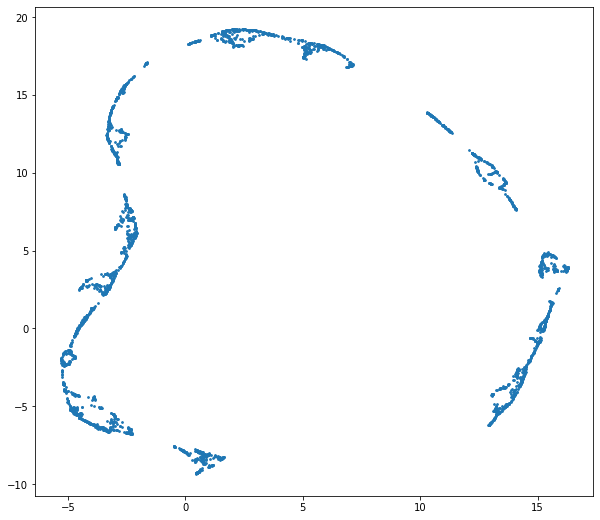

In [26]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')
plt.savefig(base_path + '/figures/plt/' + 'umap.jpg')

In [21]:
def aggregate_vectors(watch):
    watch_vec = []
    for i in watch:
        try:
            watch_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(watch_vec, axis=0)

In [22]:
similar_watch(aggregate_vectors(watch_val[0]))

[('Full Tilt Boogie (1997)', 0.928223729133606),
 ('Cavalcade (1933)', 0.9252512454986572),
 ('Murder! (1930)', 0.9232173562049866),
 ('Digging to China (1998)', 0.9197457432746887),
 ('Second Jungle Book: Mowgli & Baloo, The (1997)', 0.9195589423179626),
 ('Saltmen of Tibet, The (1997)', 0.9193097949028015)]